In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets, svm, tree
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

In [2]:
# http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29
# http://archive.ics.uci.edu/ml/datasets/Mammographic+Mass
# http://archive.ics.uci.edu/ml/datasets/Thoracic+Surgery+Data

In [3]:
X = dict()
y = dict()

# Load WDBC dataset
data = np.loadtxt("wdbc.data", delimiter=',')
X[0] = data[:, 2:]
y[0] = data[:,  1]

# Load Mammogram Mass dataset
data = np.loadtxt("mmass.data", delimiter=',')
X[1] = data[:, :5]
y[1] = data[:,  5]

# Load Thoraric Surgery dataset
data = np.loadtxt("ts.data", delimiter=',')
X[2] = data[:, :27]
y[2] = data[:,  27]

In [15]:
def ROC(X, y, clf, split, n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=n)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_predict)
    return fpr, tpr

def Acc(X, y, clf, split, n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=n)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

def Gmean(X, y, clf, split, n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=n)
    clf.fit(X_train, y_train)
    spec = recall_score(1 - y_test, 1 - clf.predict(X_test))
    rec = recall_score(y_test, clf.predict(X_test))
    return (spec, rec, np.sqrt(spec * rec))

def GmeanOS(X, y, clf, split, sampleratio, n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=n)
    
    num0 = np.sum(y_train == 0)
    num1 = np.sum(y_train == 1)

    old1 = np.where(y_train == 1)[0]
    new0 = np.where(y_train == 0)[0]
    new1 = np.random.choice(old1, int(num0*sampleratio) - num1)

    X_train2 = np.concatenate((X_train[new0, :], X_train[old1, :], X_train[new1, :]))
    y_train2 = np.concatenate((y_train[new0   ], y_train[old1   ], y_train[new1   ]))

    clf.fit(X_train2, y_train2)
    spec = recall_score(1 - y_test, 1 - clf.predict(X_test))
    rec = recall_score(y_test, clf.predict(X_test))
    return (spec, rec, np.sqrt(spec * rec))

def GmeanUS(X, y, clf, split, sampleratio, n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=n)
    
    num0 = np.sum(y_train == 0)
    num1 = np.sum(y_train == 1)

    new0 = np.random.choice(np.where(y_train == 0)[0], int(num1/sampleratio))
    new1 = np.where(y_train == 1)[0]

    X_train2 = np.concatenate((X_train[new0, :], X_train[new1, :]))
    y_train2 = np.concatenate((y_train[new0   ], y_train[new1   ]))
    
    clf.fit(X_train2, y_train2)
    spec = recall_score(1 - y_test, 1 - clf.predict(X_test))
    rec = recall_score(y_test, clf.predict(X_test))
    return (spec, rec, np.sqrt(spec * rec))

In [5]:
clf = dict()
# Decision tree
clf[0] = tree.DecisionTreeClassifier()
# Random Forest
clf[1] = RandomForestClassifier(n_estimators=100)
# Adaboost
clf[2] = AdaBoostClassifier(n_estimators=100)
# Naive Bayes
clf[3] = GaussianNB()
# SVM
clf[4] = svm.SVC(probability=True)
# Logistic Regression
clf[5] = linear_model.LogisticRegression(C=1e5)

In [6]:
split = 0.2

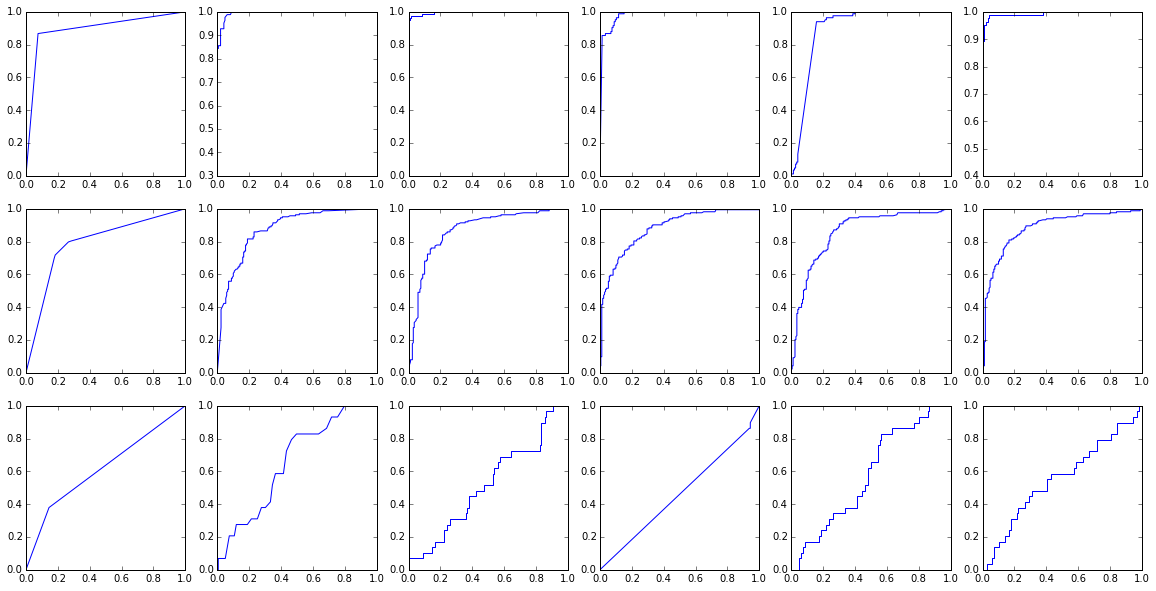

In [95]:
aucs = np.zeros((3, 6))


f = plt.figure(figsize=(20,10))
for i in xrange(0, 3):
    for c in xrange(0, 6):
        fpr, tpr = ROC(X[i], y[i], clf[c], split, 0)
        plt.subplot(3, 6, 6*i+c+1)
        plt.plot(fpr, tpr)
        aucs[i, c] = auc(fpr, tpr)
        

In [10]:
print(aucs)

[[ 0.90838361  0.99571292  0.99618927  0.97777072  0.88139092  0.99682439]
 [ 0.78205128  0.87413919  0.85648352  0.88695971  0.84974359  0.87391941]
 [ 0.49634503  0.63450292  0.53654971  0.49195906  0.48830409  0.57748538]]


In [11]:
# Wisconsin Breast Cancer Diagnostic

# ￼Machine learning techniques to diagnose breast cancer 
#   from image-processed nuclear features of fine needle aspirates

# Prospective Accuracy is 97%

accs = np.zeros((6, 1))
for c in xrange(0, 6):
    print(c),
    for n in xrange(0, 100):
        accs[c] += Acc(X[0], y[0], clf[c], split, n)
accs /= 100
print(accs)

# With AdaBoost, we obtain an accuracy of 97.0%, exactly the 97% shown
# in the paper, but within their 95.5 - 98.5 confidence interval (at the
# 95% level)

0 1 2 3 4 5 [[ 0.92640351]
 [ 0.95921053]
 [ 0.97026316]
 [ 0.93570175]
 [ 0.62885965]
 [ 0.95745614]]


In [12]:
# Mammographic Mass

# Prediction of Breast Cancer Biopsy Outcomes 
#   Using a Distributed Genetic Programming Approach

# Best AUC was 0.860 +- 0.032

aucs = np.zeros((6, 1))
for c in xrange(0, 6):
    print(c),
    for n in xrange(0, 100):
        fpr, tpr = ROC(X[1], y[1], clf[c], split, n)
        aucs[c] += auc(fpr, tpr)
aucs /= 100

print(aucs)

# We achieved an AUC of 0.9003 with Logistic Regression, which is above
# the papers metric and their uncertainty of 0.828 - 0.892

0 1 2 3 4 5 [[ 0.7904029 ]
 [ 0.87042682]
 [ 0.88976625]
 [ 0.88457892]
 [ 0.87248243]
 [ 0.90029269]]


In [25]:
# Thoracic Surgery

# Boosted SVM for extracting rules from imbalanced data in 
#   application to prediction of the post-operative life 
#   expectancy in the lung cancer patients

# The reported best geometric mean was 0.6573 on this dataset.

# For the regular data, we only do well with simple decision trees, 
#    with a Gmean of 0.4203

# For undersampled data, we get the best results for most classifiers, 
#    with a best Gmean of 0.5888 for Logistic Regression

# For oversampled data, we get the best results for SVM + LR, 
#    with a best Gmean of 0.6032 for Logistic Regression




sampleratio = .8

gms = np.zeros((6, 6))
for c in xrange(0, 6):
    print(c)
    for n in xrange(0, 100):
        #gms[c, 0] += Gmean  (X[2], y[2], clf[c], split, n)[2]
        GU = GmeanUS(X[2], y[2], clf[c], split, sampleratio, n)
        GO = GmeanOS(X[2], y[2], clf[c], split, sampleratio, n)
        gms[c, 0] += GU[0]
        gms[c, 1] += GU[1]
        gms[c, 2] += GU[2]
        gms[c, 3] += GO[0]
        gms[c, 4] += GO[1]
        gms[c, 5] += GO[2]
gms /= 100

print(gms)

0
1
2
3
4
5
[[ 0.57503772  0.51571595  0.53837511  0.8661023   0.18139842  0.37278197]
 [ 0.67528784  0.46220476  0.55060964  0.94992196  0.06628578  0.19980113]
 [ 0.60976111  0.49757788  0.54083439  0.81667094  0.27069754  0.45327128]
 [ 0.60339233  0.51258066  0.41894119  0.03398173  0.96277753  0.16422191]
 [ 0.76733714  0.23252801  0.38297406  0.80356726  0.22133842  0.3977066 ]
 [ 0.70839961  0.45879973  0.55655255  0.7855265   0.39119785  0.54177315]]


In [131]:
split = 0.2
#clft = svm.SVC(probability=True, class_weight={1: 6})
#clft = linear_model.LogisticRegression(C=1e5, class_weight={1: 6})
#clft = GaussianNB()

X_train, X_test, y_train, y_test = train_test_split(X[2], y[2], test_size=split)
clft.fit(X_train, y_train)
spec = recall_score(1-y_test, 1-clft.predict(X_test))
rec = recall_score(y_test, clft.predict(X_test))
print(y_test)
print(clft.predict(X_test))
print(np.sqrt(spec * rec))

[ 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.
  0.  0.  0.  0.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]
0.156173761889


In [98]:
num0 = np.sum(y_train == 0)
num1 = np.sum(y_train == 1)

new0 = np.where(y_train == 0)[0]
new1 = np.random.choice(np.where(y_train == 1)[0], num0)

X_train2 = np.concatenate((X_train[new0, :], X_train[new1, :]))
y_train2 = np.concatenate((y_train[new0   ], y_train[new1   ]))

print(new1)

[ 94 281 281  67  59  40  87 281 207  27  43  40  87 128 138 193 157 202
 201 201 201 254  59  40 169 147 200 193 178 155 157 281 201 207 106 190
 138 147 193   3 213  94 190  58  58 227  17 213 213 169  43 207 203 141
  40 138  40 202  27 178 128 138 140 142 172 193 141 155  40 254 178 155
 276 273  94 132 254  59  59 132  58 157 106 203 140  40  87 227   3 193
 273   3 141 178 254  40 202  67 213 157 200 157 207  27 128 202  94 201
 203 172  94 207 140 132  43 132 276 190 203 138 227 227  59 140 193 169
 141 178   3 207 201 128  43  87 132 203  67  67 147 200  24 276  74 164
  17  74 169  94 155 128  40  43  59 157 147 213  94 276 178 155  74 200
 200 142 147 155 169 142 203 178  67 200 141 207 157  24 138 142 164  55
 157  94 213  17 195  67 142 140 178  43 106   3 195 164 142 276  67 178
 140  55 227 155 276 172 140  17  40  40 132 254  27 138 132  87 213 201
 132 128 254  55  94  40 164  17 195  40 276 200  43 147 213 202 157 132
  40  58  67  24  55  43 276]


In [58]:
np.shape(X_train2)

(466L, 27L)

In [59]:
np.shape(y_train2)

(466L,)

In [46]:
np.sum(y_train == 0)

233

In [26]:
print(np.sum(y[0]==0), np.sum(y[0]==1))
print(np.sum(y[1]==0), np.sum(y[1]==1))
print(np.sum(y[2]==0), np.sum(y[2]==1))

(357, 212)
(427, 403)
(400, 70)
